# Naive Bayes

In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
from nltk.util import ngrams
from collections import Counter
from collections import defaultdict
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv('https://github.com/modos/ML-AI/raw/refs/heads/main/datasets/ml_hw3/finalSentimentdata2.csv')

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')



country_names = ["italy", "uk", "usa", "china", "brazil", "vietnam", "us", "india", "bangladesh", "singapore"]
other_words = ["please","go","sir","would","covid","time","govt","corona","pandemic","home","cases","virus","coronavirus","people", "im", "world", "four_oclock", "pic", "hello", "tamilnadu", "trump", "say" "home", "going", "day", "lockdown", "due", "get", "officers", "kim"]

min_frequency = 5
max_frequency = 0.9 * len(data)

def preprocess_text(text, n=2):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\b(twitter)\b', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if len(token) > 1]
    tokens = [w for w in tokens if w.lower() not in country_names]
    tokens = [w for w in tokens if w.lower() not in other_words]
    tokens = [w for w in tokens if not w in stop_words]

    text = " ".join(tokens)
    return text

data['processed_text'] = data['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
def get_top_n_words(corpus, n=None):
    vec = Counter()
    for text in corpus:
        for word in text.split():
            vec[word] += 1
    return vec.most_common(n)

top_words = get_top_n_words(data['processed_text'], 20)
top_words

[('like', 143),
 ('one', 134),
 ('need', 111),
 ('new', 107),
 ('good', 105),
 ('stay', 104),
 ('think', 99),
 ('days', 98),
 ('help', 93),
 ('also', 92),
 ('death', 91),
 ('take', 91),
 ('government', 91),
 ('stop', 90),
 ('crisis', 90),
 ('work', 88),
 ('via', 88),
 ('many', 86),
 ('spread', 85),
 ('today', 84)]

In [ ]:
def get_top_words(sentiment, exclude_sentiments):
    text = " ".join(data[data['sentiment'] == sentiment]['processed_text'].tolist())
    words = text.split()
    word_counts = Counter(words)

    excluded_words = []
    for sentiment in exclude_sentiments:
      excluded_text = " ".join(data[data['sentiment'] == sentiment]['processed_text'].tolist())
      excluded_words.extend(excluded_text.split())

    excluded_word_counts = Counter(excluded_words)

    filtered_word_counts = {word: count for word, count in word_counts.items() if word not in excluded_word_counts or excluded_word_counts[word] < count}

    return Counter(filtered_word_counts).most_common(20)


fear_top_words = get_top_words('fear', ['joy', 'sad', 'anger'])
print("Top 10 most common words in fear (excluding joy, sadness, and anger):")
print(fear_top_words)

anger_top_words = get_top_words('anger', ['joy', 'fear', 'sad'])
print("\nTop 10 most common words in anger (excluding joy, fear, and sadness):")
print(anger_top_words)

joy_top_words = get_top_words('joy', ['anger', 'fear', 'sad'])
print("\nTop 10 most common words in joy (excluding joy, fear, and sadness):")
print(joy_top_words)

sad_top_words = get_top_words('sad', ['anger', 'fear', 'joy'])
print("\nTop 10 most common words in joy (excluding joy, fear, and sadness):")
print(sad_top_words)

Top 10 most common words in fear (excluding joy, sadness, and anger):
[('think', 50), ('flu', 50), ('panic', 50), ('fear', 40), ('concerns', 35), ('worried', 27), ('threat', 26), ('sick', 25), ('fears', 23), ('dangerous', 21), ('worry', 20), ('scared', 14), ('least', 14), ('scary', 14), ('might', 14), ('someone', 13), ('afraid', 12), ('thinking', 12), ('concern', 12), ('system', 12)]

Top 10 most common words in anger (excluding joy, fear, and sadness):
[('shit', 44), ('shut', 26), ('fucking', 26), ('fuck', 26), ('president', 26), ('hoax', 25), ('chinese', 21), ('called', 19), ('bill', 17), ('damn', 17), ('americans', 16), ('democrats', 15), ('stupid', 15), ('hate', 15), ('anything', 13), ('hell', 12), ('racist', 12), ('idiots', 11), ('ass', 11), ('administration', 10)]

Top 10 most common words in joy (excluding joy, fear, and sadness):
[('good', 65), ('life', 36), ('best', 33), ('thanks', 30), ('safe', 30), ('thank', 30), ('great', 29), ('love', 28), ('folded_hands', 28), ('ji', 24),

In [ ]:
def remove_uncommon_words(processed_text, sentiment):
    words = processed_text.split()
    if sentiment == 'fear':
        filtered_words = [word for word in words if word in dict(fear_top_words)]
    elif sentiment == 'anger':
        filtered_words = [word for word in words if word in dict(anger_top_words)]
    elif sentiment == 'joy':
        filtered_words = [word for word in words if word in dict(joy_top_words)]
    elif sentiment == 'sad':
        filtered_words = [word for word in words if word in dict(sad_top_words)]
    else:
        filtered_words = words
    return " ".join(filtered_words)


data['processed_text'] = data.apply(lambda row: remove_uncommon_words(row['processed_text'], row['sentiment']), axis=1)

In [ ]:
data = data[data['processed_text'].str.len() > 0]
data.reset_index(drop=True, inplace=True)

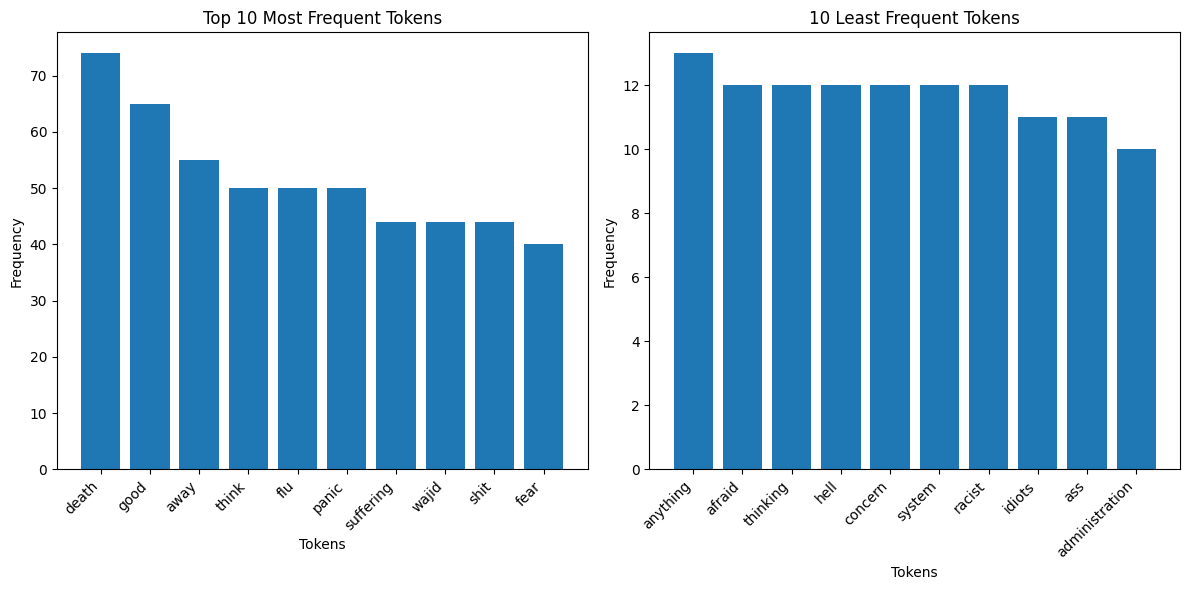

In [ ]:
dictionary = Dictionary([text.split() for text in data['processed_text']])
corpus = [dictionary.doc2bow(text.split()) for text in data['processed_text']]

frequency = defaultdict(int)
for text in data['processed_text']:
    for token in text.split():
        frequency[token] += 1

sorted_tokens = sorted(frequency.items(), key=lambda item: item[1], reverse=True)

top_10_tokens = sorted_tokens[:10]
least_10_tokens = sorted_tokens[-10:]


top_tokens_names = [token[0] for token in top_10_tokens]
top_tokens_freq = [token[1] for token in top_10_tokens]
least_tokens_names = [token[0] for token in least_10_tokens]
least_tokens_freq = [token[1] for token in least_10_tokens]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(top_tokens_names, top_tokens_freq)
plt.title('Top 10 Most Frequent Tokens')
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
plt.bar(least_tokens_names, least_tokens_freq)
plt.title('10 Least Frequent Tokens')
plt.xlabel('Tokens')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
def simple_bayes_classifier(X_train, y_train, X_test, vocab):
    class_counts = {}
    word_counts = {}

    for i in range(len(X_train)):
        label = y_train[i]
        if label not in class_counts:
            class_counts[label] = 0
            word_counts[label] = defaultdict(int)
        class_counts[label] += 1
        for word in X_train[i]:
            word_counts[label][word] += 1

    predictions = []
    for document in X_test:
        probs = {}
        for label in class_counts:
            prob = np.log(class_counts[label] / len(X_train))
            for word in document:
                if word in vocab:
                  prob += np.log((word_counts[label][word] + 1) / (sum(word_counts[label].values()) + len(vocab)))
            probs[label] = prob


            fear_count = sum(1 for word in document if word in [word for word, count in fear_top_words])
            anger_count = sum(1 for word in document if word in [word for word, count in anger_top_words])

        if anger_count > fear_count:
            probs['anger'] /= 2
        elif fear_count > anger_count:
            probs['fear'] /= 2


        predictions.append(max(probs, key=probs.get))
    return predictions


vector_sizes = range(100, 300, 100)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []
df = None

for vector_size in vector_sizes:
    top_tokens = [token[0] for token in sorted_tokens[:vector_size]]

    accuracy_scores = []
    f1_scores = []

    for train_index, test_index in kf.split(data):
        X_train = data.loc[train_index, 'processed_text'].apply(lambda x: [word for word in x.split() if word in top_tokens]).to_list()
        y_train = data.loc[train_index, 'sentiment'].to_list()
        X_test = data.loc[test_index, 'processed_text'].apply(lambda x: [word for word in x.split() if word in top_tokens]).to_list()
        y_test = data.loc[test_index, 'sentiment'].to_list()


        y_pred = simple_bayes_classifier(X_train, y_train, X_test, top_tokens)

        df = pd.DataFrame({'x_test': data.loc[test_index, 'text'], 'y_pred': y_pred, 'y_test': data.loc[test_index, 'sentiment']})
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        accuracy_scores.append(acc)
        f1_scores.append(f1)

    results.append({
        'vector_size': vector_size,
        'accuracy': np.mean(accuracy_scores),
        'f1_score': np.mean(f1_scores)
    })

results_df = pd.DataFrame(results)
print("max acc:", max(accuracy_scores), "max f1:", max(f1_scores))
results_df

max acc: 1.0 max f1: 1.0


,vector_size,accuracy,f1_score
0,100,1.0,1.0
1,200,1.0,1.0


In [ ]:
df

,x_test,y_pred,y_test
1,uk records lowest daily virus death toll since...,sad,sad
8,what worries me most these days me and a lot o...,fear,fear
13,two weeks ago i celebrated my birthday with a ...,joy,joy
14,good morning twittizens wish you a corona free...,joy,joy
16,threat assessment for march 9th back in black,fear,fear
...,...,...,...
1321,one of the biggest issues we face is the menta...,fear,fear
1324,scientist says a coronavirus vaccine in just 1...,joy,joy
1325,hey fuck off imma celebrate my roots and you c...,fear,fear
1331,i love this my fear is the constant barraging ...,fear,fear


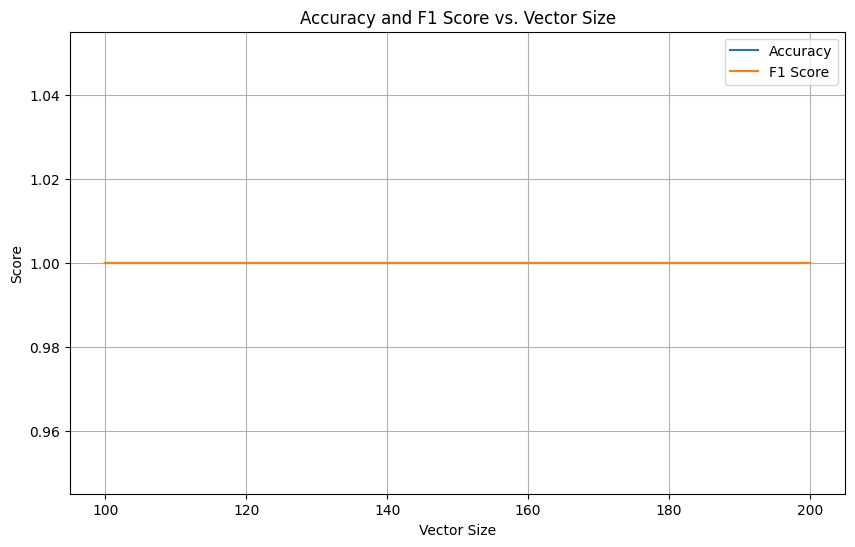

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(results_df['vector_size'], results_df['accuracy'], label='Accuracy')
plt.plot(results_df['vector_size'], results_df['f1_score'], label='F1 Score')
plt.xlabel('Vector Size')
plt.ylabel('Score')
plt.title('Accuracy and F1 Score vs. Vector Size')
plt.legend()
plt.grid(True)
plt.show()

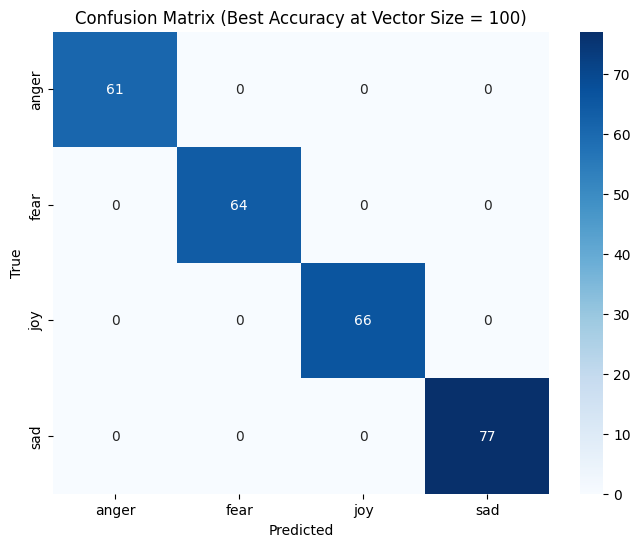

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

best_vector_size = 100

top_tokens = [token[0] for token in sorted_tokens[:best_vector_size]]
X_train = data.loc[train_index, 'processed_text'].apply(lambda x: [word for word in x.split() if word in top_tokens]).to_list()
y_train = data.loc[train_index, 'sentiment'].to_list()
X_test = data.loc[test_index, 'processed_text'].apply(lambda x: [word for word in x.split() if word in top_tokens]).to_list()
y_test = data.loc[test_index, 'sentiment'].to_list()

y_pred = simple_bayes_classifier(X_train, y_train, X_test, top_tokens)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Best Accuracy at Vector Size = {best_vector_size})')
plt.show()

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['processed_text'])
y = data['sentiment']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        63
        fear       1.00      1.00      1.00        68
         joy       1.00      1.00      1.00        78
         sad       1.00      1.00      1.00        60

    accuracy                           1.00       269
   macro avg       1.00      1.00      1.00       269
weighted avg       1.00      1.00      1.00       269

